In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from ipywidgets import interactive
from scipy.fftpack import fft, ifft,ifftshift,fftshift
from IPython.display import display, HTML
from scipy.linalg import circulant



#### --------- Definition of variables ------------------------

N_size=5001 #
Gamma=0.5
Lambda=0.5

#### ------------------------------------------------------------


def Create_circulant_slow(array_elements):
    N=len(array_elements)
    T=np.zeros((N,N))
    for i in range(N-1):
        T[i+1,i]=1
    T[0,N-1]=1
    circulant_matrix=array_elements[0]*np.eye(N)
    result=T
    for i in range(1,N):
        circulant_matrix+=result*array_elements[i]
        result=np.matmul(result,T)
    return circulant_matrix

def Create_circulant(array_elements):
    N=len(array_elements)
    if N%2==0:
        array_elements=np.roll(array_elements,N//2)
    else:
        array_elements=np.roll(array_elements,N//2+1)
    circulant=[]
    for i in range(N):
        circulant.append(np.roll(array_elements,i))
    return np.array(circulant)

def Create_anti_circulant(array_elements):
    N=len(array_elements)
    if N%2==0:
        array_elements=np.roll(array_elements,N//2)
    else:
        array_elements=np.roll(array_elements,N//2+1)
    circulant=[]
    for i in range(N):
        circulant.append(np.roll(array_elements[::-1],-i))
    return np.array(circulant)

display(HTML("""
<style>
.output {
    display: flex;
    align-items: left;
    text-align: center;
}
</style>
"""))

def Alpha(Gamma,Lambda,theta):
    return Lambda+np.cos(theta)
def Beta(Gamma,Lambda,theta):
    return Gamma*np.sin(theta)
def Omega(Gamma,Lambda,theta):
    return np.sqrt(Alpha(Gamma,Lambda,theta)**2 + Beta(Gamma,Lambda,theta)**2 )
def Phi(Gamma,Lambda,theta):
    return np.arctan2(Beta(Gamma,Lambda,theta),Alpha(Gamma,Lambda,theta))



### ----------------------- Fourier theoric ----------------------------------

def Fourier_theoric(random_numbers_m,Gamma,Lambda,N_size):   
    result=np.zeros(N_size)
    index_result=0
    for w in np.arange(-(N_size-1)/2,(N_size-1)/2 +1):
        result[index_result]=random_numbers_m[0]+np.sum([2*random_numbers_m[i]*np.cos(Phi(Gamma,Lambda,2.0*np.pi/N_size * i) - w*2*np.pi/N_size*i) for i in range(1,(N_size-1)//2 +1)]) 
        index_result+=1
    return result

## ------------------ My own fourier transform -------------------------------------
def FT(x):
    N = len(x)
    X = np.zeros(N, dtype=complex)
    ind_1=0
    for k in np.arange(-(N-1)/2,(N-1)/2+1):
        X[ind_1] = 0.0j
        ind_2=0
        for n in np.arange(-(N-1)/2,(N-1)/2+1):
            X[ind_1] += x[ind_2] *np.exp(-1.0j*(2.0*np.pi/(N))*k*n) #(np.cos((2.0*np.pi/(N))*k*n))#
            #print(n, X[ind_1])
            ind_2+=1
        #print(k,X[ind_1])
        ind_1+=1
    return X

def Fermi_dirac(beta,mu,n,Gamma=Gamma,Lambda=Lambda,N=N_size):
    # beta is the inverse thermic energy associated in the system (beta)
    # mu corresponds to the chemical potential
    # n is the position of the particle
    # f=np.exp(T*(Omega(Gamma,Lambda,2.0*(np.pi/N)*n)-mu)) +1
    # N corresponds to the size of the system
    f=np.exp(beta*(Omega(Gamma,Lambda,((2.*np.pi)/float(N)) * n)-mu)) +1
    return 1/f

def plot_interactive(beta,mu):
    plt.figure(figsize=(10,7))
    n=np.arange(-(N_size-1)/2,(N_size-1)/2+ 1)
    plt.subplot(2,1,1)
    plt.plot(n,Fermi_dirac(beta,mu,n))
    #plt.ylim(-0.05,1.05)
    plt.xlabel("Position")
    plt.ylabel("Probability")
    plt.subplot(2,1,2)
    plt.plot(n,Omega(Gamma,Lambda,(2.*np.pi)/float(N_size)*n),label=r"$\Omega$")
    plt.show()

In [2]:
n=np.arange(-(N_size-1)/2,(N_size-1)/2+ 1)
gap_temp=np.min(Omega(Gamma,Lambda,(2.*np.pi)/float(N_size)*n))

interactive_plot = interactive(plot_interactive, beta=gap_temp, mu=0)
output = interactive_plot.children[-1]
output.layout.height = '450px'
interactive_plot

interactive(children=(FloatSlider(value=0.40824829386304334, description='beta', max=1.22474488158913, min=-0.…

In [3]:
x=np.arange(0,(N_size-1)/2+ 1)
beta=gap_temp
mu=0
m_cos=[-0.5 if np.random.random()>Fermi_dirac(beta,mu,i) else 0.5 for i in x]
m_sin=[-0.5 if np.random.random()>Fermi_dirac(beta,mu,i) else 0.5 for i in x]
m_cos=np.array(m_cos[1:][::-1]+m_cos)
m_sin=np.array(m_sin[1:][::-1]+m_sin)
M_plus=(m_cos+m_sin)*0.5
M_minous=(m_cos-m_sin)*0.5
x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)
Mplusband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
Mplusband=M_plus*np.array(Mplusband)
Mminousband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
Mminousband=M_minous*np.array(Mminousband)

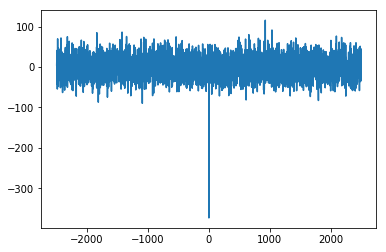

In [4]:
x=np.arange(-(N_size-1)/2,(N_size-1)/2+ 1)
Fourier_plus=fftshift(fft(ifftshift(Mplusband)))
Fourier_minous=fftshift(fft(ifftshift(Mminousband)))
plt.plot(x,Fourier_plus.real)

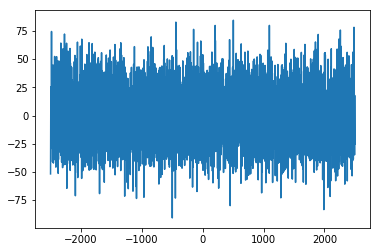

In [5]:
x=np.arange(-(N_size-1)/2,(N_size-1)/2+ 1)
plt.plot(x,Fourier_minous.real)

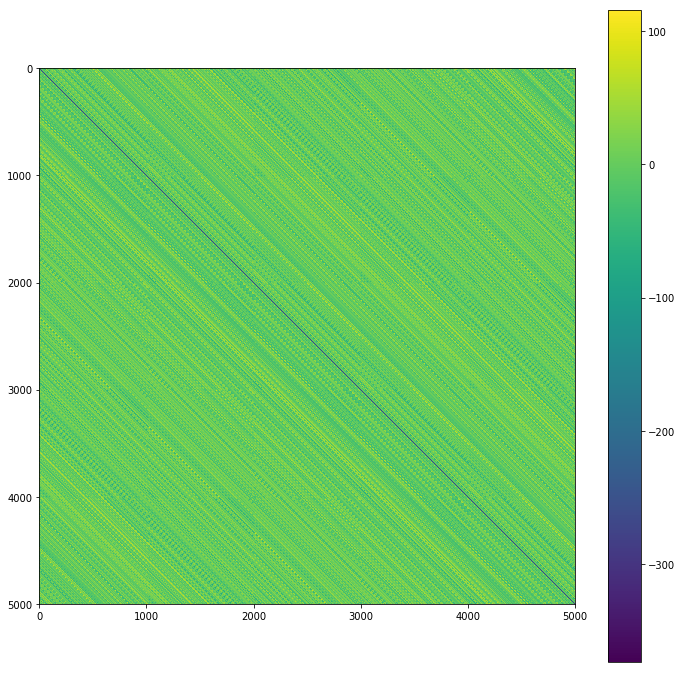

In [6]:
plt.figure(figsize=(12,12))
plt.imshow(Create_circulant(Fourier_plus.real))
plt.colorbar()
plt.show()

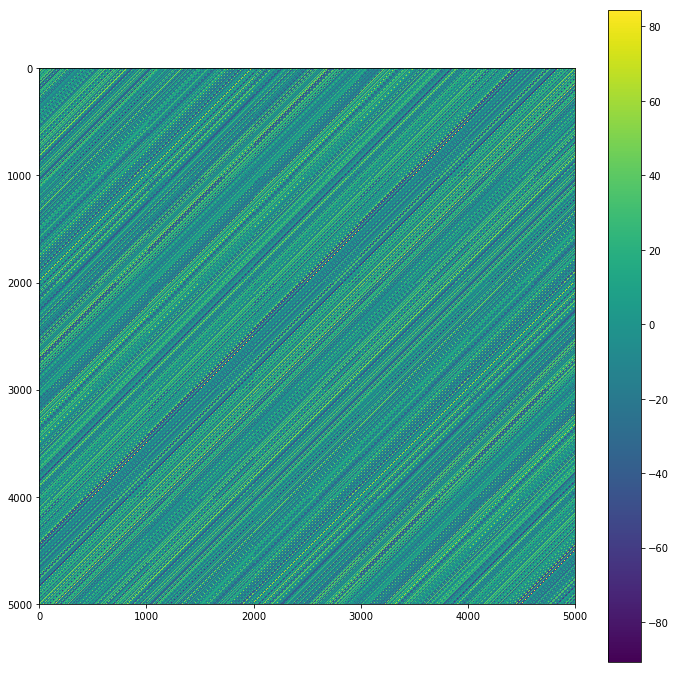

In [7]:
plt.figure(figsize=(12,12))
plt.imshow(Create_anti_circulant(Fourier_minous.real))
plt.colorbar()
plt.show()

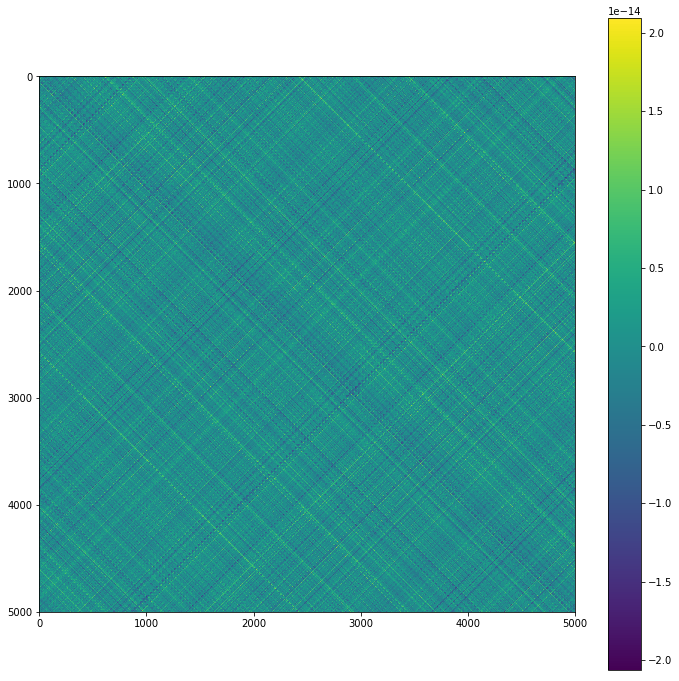

In [8]:
plt.figure(figsize=(12,12))
plt.imshow(Create_anti_circulant(Fourier_minous.imag)+Create_circulant(Fourier_plus.imag))
plt.colorbar()
plt.show()

# take a portion of the matrix

In [9]:
def take_portion_of_matrix(matrix,size):
    if size == matrix.shape[0]:
        return matrix.copy()
    
    else:
        row=matrix.shape[0]
        column=matrix.shape[0]
        while  (row + size) >= matrix.shape[0] and (column + size) >= matrix.shape[1]:
            row=np.random.randint(0,matrix.shape[0]-size+1)
            column=np.random.randint(0,matrix.shape[0]-size+1)
        #print(row,row+size,column,column+size)
        new_matrix=matrix[row:row+size,column:column+size]
        return new_matrix
def Take_portion(matrix,size,copy=True):
    if copy:
        new_matrix=matrix.copy()
        return new_matrix[:size,:size]
    else:
        return matrix[:size,:size]

In [10]:
Cov_matrix=(Create_anti_circulant(Fourier_minous)+Create_circulant(Fourier_plus))*1/N_size

In [11]:

result=[]
for i in range(50, 500,10):
    New_Cov_matrix=Take_portion(Cov_matrix,i)
    A,S,B=np.linalg.svd(New_Cov_matrix)
    aux=np.sum((-(S+0.5)np.log((S+0.5))-(-S+0.5)*np.log(-S+0.5)))
    result.append(aux)

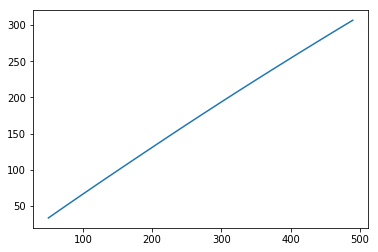

In [12]:
plt.plot(range(50, 500,10),result)

# Test for ground state

In [13]:
M_plus=np.ones(N_size)
M_minous=np.zeros(N_size)
x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)
Mplusband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
Mplusband=M_plus*np.array(Mplusband)
Mminousband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
Mminousband=M_minous*np.array(Mminousband)
Fourier_plus=fftshift(fft(ifftshift(Mplusband)))
Fourier_minous=fftshift(fft(ifftshift(Mminousband)))
Cov_matrix=(Create_anti_circulant(Fourier_minous)+Create_circulant(Fourier_plus))*1/N_size

In [14]:
result=[]
for i in range(50, 500,10):
    New_Cov_matrix=Take_portion(Cov_matrix,i)
    A,S,B=np.linalg.svd(New_Cov_matrix)
    aux=np.sum((-(S[:-1]+0.5)*np.log(S[:-1]+0.5)-(-S[:-1]+0.5)*np.log(-S[:-1]+0.5)))
    result.append(aux)

/Users/josealejandromontanacortes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
